# Students:

### Le Hoang Sang

### Vu Dinh Chuong

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from torch import nn
import torch.optim as optim

# CLean data

In [198]:
def clean_data(df):
    print("Initial data information:")
    print(df.info())

    # Remove unnecessary columns (if there are columns named 'Unnamed')
    df = df.loc[:, ~df.columns.get_level_values(1).str.contains('^Unnamed')]

    # Handle the 'timestamp' column (if present)
    if ('timestamp', '') in df.columns:
        # Convert to datetime format
        df[('timestamp', '')] = pd.to_datetime(df[('timestamp', '')], errors='coerce')  
        
        # Remove rows with missing timestamp values
        df = df.dropna(subset=[('timestamp', '')]) 

    # Fill missing values using forward fill and backward fill methods
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Normalize 'close' values between 0 and 1 if present
    if ('close', '') in df.columns:
        df[('close', '')] = (df[('close', '')] - df[('close', '')].min()) / (df[('close', '')].max() - df[('close', '')].min())

    # Print out the data after cleaning
    print("Data after cleaning:")
    print(df.head())

    return df


# Create features

In [199]:
def create_features(df):
    df_features = df.copy()

    print("Column names in the DataFrame:", df_features.columns)

    # Define the symbol you want to work with (e.g., 'A', 'AAL', etc.)
    symbol = 'A'

    # Define the columns for the selected stock symbol
    numeric_cols = [(symbol, 'open'), (symbol, 'high'), (symbol, 'low'), (symbol, 'close'), (symbol, 'volume')]

    # Check if these columns exist in the DataFrame
    existing_cols = [col for col in numeric_cols if col in df_features.columns]

    if not existing_cols:
        raise ValueError("Required numeric columns not found in the DataFrame.")

    # Convert the necessary columns to numeric type
    df_features[existing_cols] = df_features[existing_cols].apply(pd.to_numeric, errors='coerce')

    # Remove rows with NaN values after conversion
    df_features = df_features.dropna()

    # Create features if the necessary columns exist
    if (symbol, 'close') in df_features.columns:
        df_features[(symbol, 'return')] = df_features[(symbol, 'close')].pct_change()
        df_features[(symbol, 'ma7')] = df_features[(symbol, 'close')].rolling(window=7).mean()
        df_features[(symbol, 'ma21')] = df_features[(symbol, 'close')].rolling(window=21).mean()
        df_features[(symbol, 'volatility')] = df_features[(symbol, 'close')].rolling(window=7).std()
    
    if (symbol, 'open') in df_features.columns and (symbol, 'close') in df_features.columns:
        df_features[(symbol, 'open_close_ratio')] = df_features[(symbol, 'open')] / df_features[(symbol, 'close')]
    
    if (symbol, 'high') in df_features.columns and (symbol, 'low') in df_features.columns:
        df_features[(symbol, 'high_low_ratio')] = df_features[(symbol, 'high')] / df_features[(symbol, 'low')]

    # Remove rows with NaN values due to calculations
    df_features = df_features.dropna()  

    print("DataFrame with new features:")
    print(df_features.head())

    return df_features

# Plot data

In [200]:
def plot_features(df_features, symbol='A'):
    # Ensure symbol exists in the DataFrame
    if symbol not in df_features.columns.get_level_values(0):
        raise ValueError(f"Symbol '{symbol}' not found in DataFrame columns.")

    # Plot the 'close' price
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'close')], label=f'{symbol} Close Price', color='b')
    plt.title(f'{symbol} Close Price Over Time')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    # Plot the 7-day and 21-day moving averages
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'ma7')], label=f'{symbol} MA7', color='g')
    plt.plot(df_features.index, df_features[(symbol, 'ma21')], label=f'{symbol} MA21', color='r')
    plt.title(f'{symbol} 7-day and 21-day Moving Averages')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Plot the volatility (7-day rolling standard deviation)
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'volatility')], label=f'{symbol} Volatility (7-day)', color='purple')
    plt.title(f'{symbol} Volatility (7-day rolling std)')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

    # Plot the open/close ratio
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'open_close_ratio')], label=f'{symbol} Open/Close Ratio', color='orange')
    plt.title(f'{symbol} Open/Close Ratio Over Time')
    plt.xlabel('Time')
    plt.ylabel('Ratio')
    plt.legend()
    plt.show()

    # Plot the high/low ratio
    plt.figure(figsize=(14, 7))
    plt.plot(df_features.index, df_features[(symbol, 'high_low_ratio')], label=f'{symbol} High/Low Ratio', color='brown')
    plt.title(f'{symbol} High/Low Ratio Over Time')
    plt.xlabel('Time')
    plt.ylabel('Ratio')
    plt.legend()
    plt.show()

# Run flow

In [201]:
df = pd.read_csv('./newfile.csv', index_col=0, header=[0, 1]).sort_index(axis=1)

# Drop the 'Adj Close' column
df.drop('Adj Close', axis=1, inplace=True)

In [202]:
df_cleaned = clean_data(df)

Initial data information:
<class 'pandas.core.frame.DataFrame'>
Index: 8371 entries, 2024-11-18 14:31:00+00:00 to 2024-12-18 16:52:00+00:00
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   (Close, 226.1999969482422)  8371 non-null   float64
 1   (High, 226.41000366210932)  8371 non-null   float64
 2   (Low, 225.17999267578125)   8371 non-null   float64
 3   (Open, 225.1999969482422)   8371 non-null   float64
 4   (Volume, 1331036.0)         8371 non-null   float64
dtypes: float64(5)
memory usage: 392.4+ KB
None
Data after cleaning:
Date                                  Close               High  \
2024-11-18 14:30:00+00:00 226.1999969482422 226.41000366210932   
2024-11-18 14:31:00+00:00        226.565994         226.639999   
2024-11-18 14:32:00+00:00        226.679993         226.880005   
2024-11-18 14:33:00+00:00        226.410004         226.820007   
2024-11-18 14:34:00+00:00     

C:\Users\LT MSI\AppData\Local\Temp\ipykernel_8708\1215159712.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [203]:
# Split train from  11/09/2017 9:30 A.M. to 17/01/2018 11:50 A.M and test data  from 17/01/2018 11:51A.M. to 16/02/2018 03:59A.M
train = df.loc['2024-11-18 14:30:00+00:00':'2024-12-12 19:40:00+00:00']
test = df.loc['2024-12-12 19:41:00+00:00':'2024-12-18 16:52:00+00:00']

In [204]:
# Create sequences of data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Create sequences with a length of 100
seq_length = 100
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Create data loaders
train_data = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
test_data = TensorDataset(torch.tensor(X_test).float(), torch.from_numpy(y_test).float())

batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [205]:
class VanillaLSTM(nn.Module):
    def __init__(self, num_feature):
        super(VanillaLSTM, self).__init__()
        self.lstm  = nn.LSTM(num_feature,64,batch_first=True)
        self.fc    = nn.Linear(64,num_feature)
        
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.fc(hidden)
        return x

model = VanillaLSTM(5)

In [206]:
# RMSE loss function
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [207]:
def train(dataloader):
    epoch_loss = 0
    model.train()  
    
    for batch in dataloader:
        optimizer.zero_grad()          
        x,y = batch
        pred = model(x)
        loss = criterion(pred[0],y)        
        loss.backward()               
        optimizer.step()      
        epoch_loss += loss.item()  
        
    return epoch_loss

In [208]:
def evaluate(dataloader):
    epoch_loss = 0
    model.eval()  
    
    with torch.no_grad():
      for batch in dataloader:   
          x,y= batch
          pred = model(x)
          loss = criterion(pred[0],y)              
          epoch_loss += loss.item()  
        
    return epoch_loss / len(dataloader)

In [209]:
n_epochs = 600
best_valid_loss = float('inf')

for epoch in range(1, n_epochs + 1):
    train_loss = train(train_loader)
    valid_loss = evaluate(test_loader)
    
    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, './checkpoint/saved_weights.pt')

    if (epoch % 200 == 0):
        print(f'\tEpoch: {epoch} | ' + f'\tTrain Loss: {train_loss:.5f} | ' + f'\tVal Loss: {valid_loss:.5f}\n')

KeyboardInterrupt: 

In [210]:
model=torch.load('./checkpoint/saved_weights.pt')

In [211]:
X_test = torch.tensor(X_test).float()

with torch.no_grad():
  y_test_pred = model(X_test)

y_test_pred = y_test_pred.numpy()[0]


# # test y_test_pred first column
# y_pred_close = y_test_pred[:, :1]
# y_test_close = y_test[:, :1]

In [212]:
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred, multioutput='raw_values'))
mse = mean_squared_error(y_test, y_test_pred, multioutput='raw_values')
mae = mean_absolute_error(y_test, y_test_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_test_pred, multioutput='raw_values')
index = ['RMSE','MSE', 'MAE', 'R2 score']

results = pd.DataFrame([rmse, mse, mae, r2], index=index, columns=['Close','High','Low','Open','Volume'])
results

,Close,High,Low,Open,Volume
RMSE,0.005854,0.004807,0.004332,0.003102,0.025932
MSE,0.000034,0.000023,0.000019,0.000010,0.000672
MAE,0.004333,0.003409,0.002725,0.001499,0.009002
R2 score,0.996090,0.997401,0.997849,0.998904,0.610336


In [213]:
# error number of all columns
error = np.abs(y_test - y_test_pred)
error = pd.DataFrame(error, columns=['Close','High','Low','Open','Volume'])
error

,Close,High,Low,Open,Volume
0,0.004475,0.005095,0.001642,0.002803,0.002561
1,0.001852,0.000625,0.000529,0.001516,0.000153
2,0.003426,0.003228,0.003184,0.000262,0.000974
3,0.003739,0.000654,0.001450,0.000960,0.001054
4,0.004440,0.001260,0.005101,0.001285,0.011226
...,...,...,...,...,...
1319,0.005534,0.003469,0.002638,0.001164,0.004643
1320,0.003104,0.002990,0.002765,0.002344,0.000614
1321,0.008240,0.007152,0.003468,0.001236,0.000759
1322,0.008311,0.005877,0.004021,0.001784,0.004377


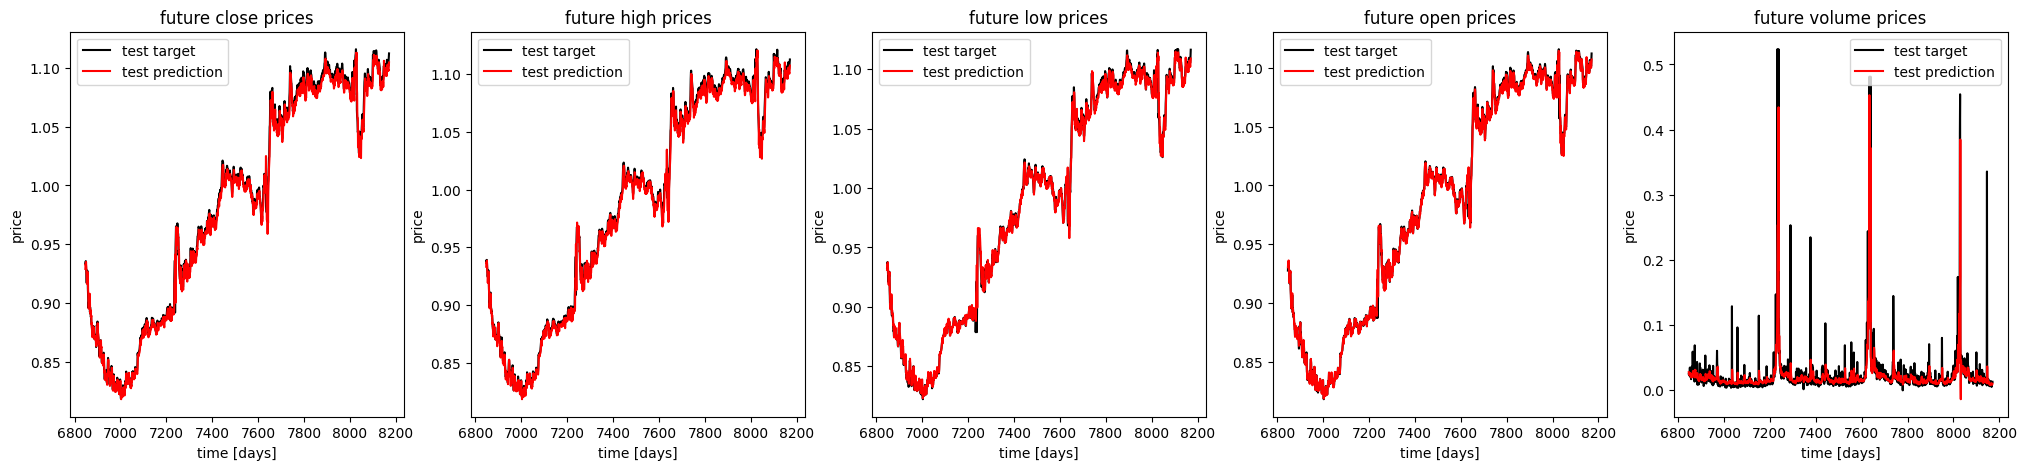

In [214]:
fig, ax = plt.subplots(nrows=1, ncols=5)
fig.set_figwidth(25)
fig.set_figheight(5)

for i in range(5):
    ax[i].plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,i], color='black', label='test target')

    ax[i].plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,i], color='red', label='test prediction')

    ax[i].set_xlabel('time [days]')
    ax[i].set_ylabel('price')
    ax[i].legend(loc='best')

ax[0].set_title('future close prices')
ax[1].set_title('future high prices')
ax[2].set_title('future low prices')
ax[3].set_title('future open prices')
ax[4].set_title('future volume prices')

plt.show()

In [215]:
# Predicting the next 10 mins

seq_len = 101
sequences = []
for index in range(len(test) - seq_len + 1): 
    sequences.append(test[index: index + seq_len])
sequences = np.array(sequences)

last_sequence = sequences[-1:, 1:, :]
last_sequence = torch.from_numpy(last_sequence).float()

# Generate predictions
PREDICT = 100
with torch.no_grad():
    for i in range(PREDICT):
        pred_i = model(last_sequence)
        last_sequence = torch.cat((last_sequence, pred_i), dim=1)
        last_sequence = last_sequence[:, 1:, :]


pred_mins = last_sequence.reshape(PREDICT, 5).numpy()

# # Inverse transform the predicted values
pred_value = scaler.inverse_transform(pred_mins)

df_pred = pd.DataFrame(
    data=pred_value,
    columns=['Close','High','Low','Open','Volume']
)

df_pred

,Close,High,Low,Open,Volume
0,248.196655,242.245087,234.555771,234.559464,-4.212530e+06
1,224.797394,228.683792,225.109253,229.250763,4.548841e+05
2,230.072372,230.387451,229.096710,229.710709,3.479184e+05
3,235.832962,236.664337,234.813080,235.364120,9.935608e+05
4,238.636902,239.368256,237.723618,238.236313,6.255214e+05
...,...,...,...,...,...
95,248.594864,248.664108,248.570206,248.613708,-5.447494e+04
96,248.579422,248.649124,248.554077,248.597992,-5.445505e+04
97,248.564087,248.634216,248.537918,248.582321,-5.427710e+04
98,248.547470,248.618439,248.518814,248.564713,-5.322603e+04


In [224]:
# Get error of last 100 mins
error_pred = np.abs(y_test[-100:] - pred_mins)

x = scaler.inverse_transform(y_test[-100:])
y = scaler.inverse_transform(pred_mins)

# error_pred = scaler.inverse_transform(error_pred)

error_pred = np.abs(x - y)


error_pred = pd.DataFrame(error_pred , columns=['Close','High','Low','Open','Volume'])

x = pd.DataFrame(x, columns=['Close','High','Low','Open','Volume'])

y = pd.DataFrame(y, columns=['Close','High','Low','Open','Volume'])

print(x)
print(y)
print(error_pred)

         Close        High         Low        Open   Volume
0   252.990005  253.039993  252.970001  253.009995  52244.0
1   253.000000  253.046799  252.934998  252.938095  47367.0
2   253.059998  253.130005  253.009995  253.009995  45794.0
3   252.789993  253.085007  252.759995  253.059998  86162.0
4   252.889999  252.947998  252.770004  252.789993  50463.0
..         ...         ...         ...         ...      ...
95  253.365005  253.377899  253.300003  253.320297  17052.0
96  253.324997  253.384995  253.324905  253.369995  25717.0
97  253.429993  253.464996  253.320007  253.320007  30301.0
98  253.528198  253.528198  253.429993  253.429993  42713.0
99  253.589996  253.589996  253.589996  253.589996  42713.0

[100 rows x 5 columns]
         Close        High         Low        Open        Volume
0   248.196655  242.245087  234.555771  234.559464 -4.212530e+06
1   224.797394  228.683792  225.109253  229.250763  4.548841e+05
2   230.072372  230.387451  229.096710  229.710709  3.479184e